In [ ]:
# Polar maps analysis
# Transfer learning for three polar maps

In [3]:
# Model ID, number of samples for validation and test subsets, CV fold
model_n=16
n_val=30
n_test=15
fold_seed=5

In [4]:
# Dependencies
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
%matplotlib inline

from keras.models import Sequential
from keras.preprocessing.image import load_img,img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img,img_to_array

Using TensorFlow backend.
/home/user/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [5]:
from keras import backend as K
K.clear_session()

In [6]:
# PATH
path='all polar maps/'
files_all=os.listdir(path)
df=pd.DataFrame(pd.read_csv('AbstractESCdeeplearning.csv'))

In [7]:
class prepare_data():
    def __init__(self,df,polarmap_name,path):
        self.df=df
        self.polarmap_name=polarmap_name
        self.path=path
        self.X_train=[]
        self.X_val=[]
        self.X_test=[]
        self.y_train=[]
        self.y_val=[]
        self.y_test=[]
        self.idxs_val=[]
        self.idxs_test=[]
        self.files_common=[]
    def read_data(self):
        """
        -First read all the polarmaps available. 
        -Then read the dataframe with all patients data.
        -Keep the indices that exist for both sources
        """
        ids=[str(i) for i in df.ID.values] # ids from file
        files_reserve=[i for i in files_all if self.polarmap_name in i]  # Get all the reserve filenames and then get only their number
        self.files_reserve_number=[str(int(i.split(self.polarmap_name)[1].split('.')[0])) for i in files_reserve] 
        self.files_common=list(set(ids).intersection(self.files_reserve_number)) # common files
        ###
        self.polar_maps=[]
        for idx,i in enumerate(self.files_common):
            jpgfile = load_img(f'{path}{self.polarmap_name}{int(self.files_common[idx]):04d}.jpg')
            image_array=img_to_array(jpgfile)
            #jpgfile = Image.open(f'{path}{files_common[idx]}')
            self.polar_maps.append(image_array)
        self.targets=[]
        for idx,i in enumerate(self.files_common):
            target=df.loc[np.where(df.ID==int(i))[0][0]].TotEVENT_def3
            self.targets.append(target)
        ###
    def fold_with_random_samples(self,the_fold,n_val,n_test):
        """
        For all the indices that exist in both sources:
        -Find the indices for both class 1 and class 0 
        -For each class get n_val samples for valdiation set and n_test samples for test set
        and the rest for the trainining set
        -Get the data in the correct format (pad and convert to array)
        """
        # Find the indices for both class 1 and class 0 
        # class 1
        self.fold_=the_fold
        np.random.seed(self.fold_)
        class1_idx=np.where(np.array(self.targets)==1)[0]
        class1_idx=np.random.permutation(class1_idx)
        class1_val=random.sample(set(class1_idx), n_val) # n_val indices for val set
        idx_not_in_val=[i for i in class1_idx if i not in class1_val] # indices not in val set
        class1_test=random.sample(set(idx_not_in_val), n_test) # n_test indices for test set
        class1_train=[i for i in class1_idx if i not in class1_val and i not in class1_test]
        #class 0 
        class0_idx=np.where(np.array(self.targets)==0)[0]
        class0_idx=np.random.permutation(class0_idx)
        class0_val=random.sample(set(class0_idx), n_val) # n_val indices for val set
        idx_not_in_val=[i for i in class0_idx if i not in class0_val] # indices not in val set
        class0_test=random.sample(set(idx_not_in_val), n_test) # n_test indices for test set
        class0_train=[i for i in class0_idx if i not in class0_val and i not in class0_test]
        # Get n_val samples for valdiation set and n_test samples for test set
        self.idxs_val=list(class0_val)+list(class1_val)
        X_val_temp=[self.polar_maps[i] for i in self.idxs_val]
        y_val_temp=[self.targets[i] for i in self.idxs_val]
        #===
        self.idxs_test=list(class0_test)+list(class1_test)
        X_test_temp=[self.polar_maps[i] for i in self.idxs_test]
        y_test_temp=[self.targets[i] for i in self.idxs_test]
        #===
        train_idxs=list(class0_train)+list(class1_train)
        X_train_temp=[self.polar_maps[i] for i in train_idxs]
        y_train_temp=[self.targets[i] for i in train_idxs]
        # Get Correct format
        X_train_temp=[np.pad(i,[(0, 1), (0, 1),(0, 0)],mode='constant') for i in X_train_temp]
        self.X_train=np.asarray(X_train_temp)
        self.y_train=np.asarray(y_train_temp)
        #self.y_train=np.expand_dims(self.y_train,-1)
        X_val_temp=[np.pad(i,[(0, 1), (0, 1),(0, 0)],mode='constant') for i in X_val_temp]
        self.X_val=np.asarray(X_val_temp)
        self.y_val=np.asarray(y_val_temp)
        #self.y_val=np.expand_dims(self.y_val,-1)
        X_test_temp=[np.pad(i,[(0, 1), (0, 1),(0, 0)],mode='constant') for i in X_test_temp]
        self.X_test=np.asarray(X_test_temp)
        self.y_test=np.asarray(y_test_temp)

In [8]:
reserve=prepare_data(df,'reserve',path)
reserve.read_data()
reserve.fold_with_random_samples(fold_seed,n_val,n_test)

In [9]:
rest=prepare_data(df,'rest',path)
rest.read_data()
rest.fold_with_random_samples(fold_seed,n_val,n_test)

In [10]:
stress=prepare_data(df,'stress',path)
stress.read_data()
stress.fold_with_random_samples(fold_seed,n_val,n_test)

In [13]:
# Check that indices are not repeated (avoid data leaking)
print(f'n train = {len(reserve.X_train)}, n val = {len(reserve.X_val)}, \
n test = {len(reserve.X_test)}')
print('Indices examples')
print(np.sort(reserve.idxs_val))
print(np.sort(reserve.idxs_test))

n train = 1095, n val = 60, n test = 30
Indices examples
[  16   41   45   86   92  120  133  138  199  207  208  239  265  295  313
  330  332  351  367  394  395  410  415  441  455  471  478  513  540  564
  596  600  602  633  658  660  661  675  677  682  691  761  870  876  909
  929  943  949  974  987 1026 1039 1049 1067 1101 1104 1112 1151 1160 1168]
[   1   31   32   49  204  266  335  349  373  422  434  439  461  489  528
  544  553  616  629  713  771  778  841  962  996 1030 1037 1090 1138 1148]


In [15]:
# Check data characteristics
print(np.min(reserve.X_train),np.max(reserve.X_val))
print(np.shape(reserve.X_train),np.shape(reserve.y_train))
print(np.shape(reserve.X_val),np.shape(reserve.y_val))
print(np.shape(rest.X_train),np.shape(rest.y_train))
print(np.shape(rest.X_val),np.shape(rest.y_val))
print(np.shape(stress.X_train),np.shape(stress.y_train))
print(np.shape(stress.X_val),np.shape(stress.y_val))

0.0 255.0
(1095, 224, 224, 3) (1095,)
(60, 224, 224, 3) (60,)
(1095, 224, 224, 3) (1095,)
(60, 224, 224, 3) (60,)
(1095, 224, 224, 3) (1095,)
(60, 224, 224, 3) (60,)


In [16]:
print(len(reserve.files_reserve_number))
print(len(rest.files_reserve_number))
print(len(stress.files_reserve_number))

1187
1187
1187


In [17]:
# Check prevalence of class1
sum(reserve.y_train)/len(reserve.y_train)

0.10410958904109589

# Use class weight instead of resampling

In [18]:
# For resampling
# https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras
prevalence = sum(reserve.y_train)/len(reserve.y_train)
resampling_factor=int(1//(prevalence)*1)
class_weight = {0 : 1.,
                1: resampling_factor}
resampling_factor

9

# Callbacks

In [19]:
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
import math
def step_decay(epoch):
    initial_lrate = 0.000001
    drop = 0.5
    epochs_drop = 5.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate
lrate = LearningRateScheduler(step_decay)
#===============
#filepath="model6_{epoch:02d}_{val_loss:.2f}.hdf5"
filepath=f"best_model{model_n}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', 
                             save_best_only=True, mode='auto')
#==============
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=.5,
                              patience=3)
callbacks=[lrate,checkpoint]

# Data generator

In [20]:
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

## Generator multiple inputs

In [21]:
def generate_generator_multiple(generator,X1,X2,X3,y, batch_size):
    genX1 = generator.flow(X1,y,
                           batch_size = batch_size,
                           shuffle=False, 
                           seed=7)
    genX2 = generator.flow(X2,y,
                           batch_size = batch_size,
                           shuffle=False, 
                           seed=7)
    genX3 = generator.flow(X3,y,
                           batch_size = batch_size,
                           shuffle=False, 
                           seed=7)
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            X3i = genX3.next()
            yield [[X1i[0], X2i[0], X3i[0]], X2i[1]]#Yield all images and their mutual label

In [22]:
batch_size=2
train_generator=generate_generator_multiple(train_datagen,
                                            reserve.X_train,
                                            stress.X_train,
                                            rest.X_train,
                                            stress.y_train,
                                            batch_size=batch_size)
valid_generator=generate_generator_multiple(valid_datagen,
                                            reserve.X_val,
                                            stress.X_val,
                                            rest.X_val,
                                            stress.y_val,
                                            batch_size=batch_size)
test_generator=generate_generator_multiple(test_datagen,
                                            reserve.X_test,
                                            stress.X_test,
                                            rest.X_test,
                                            stress.y_test,
                                            batch_size=batch_size)

# Pretrained models

In [23]:
from keras.applications import ResNet50
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, Dropout, concatenate
from keras.layers import Activation
from keras.models import Model

## Base model 1

In [24]:
input1=Input(shape=(224,224,3))
base_model1=ResNet50(weights='imagenet',include_top=False, input_tensor=input1)
#=== Rename the layers names to avoid conflicts
for i in base_model1.layers:
    i.name=f'base1_{i.name}'

In [25]:
# Intermediate layer 
layer_name = 'base1_add_9'
intermediate_layer_model1 = Model(inputs=base_model1.input,
                                 outputs=base_model1.get_layer(layer_name).output)

In [26]:
#Adding custom Layers 
# for layer in base_model1.layers:
#     layer.trainable = False
flat1 = Flatten()(intermediate_layer_model1.output)

## Base model 2

In [27]:
input2=Input(shape=(224,224,3))
base_model2=ResNet50(weights='imagenet',include_top=False, input_tensor=input2)
#=== Rename the layers names to avoid conflicts
for i in base_model2.layers:
    i.name=f'base2_{i.name}'

In [28]:
# The names numbers are not the same anymore, we need to find the right layer
layers_names=[i.name for i in base_model1.layers] # Layer in model1
name_index=layers_names.index('base1_add_9')
layers_names2=[i.name for i in base_model2.layers] # Layer in model2
print(layers_names2[name_index])

base2_add_25


In [29]:
# Intermediate layer 
layer_name = layers_names2[name_index]
intermediate_layer_model2 = Model(inputs=base_model2.input,
                                 outputs=base_model2.get_layer(layer_name).output)

In [30]:
#Adding custom Layers 
# for layer in base_model1.layers:
#     layer.trainable = False
flat2 = Flatten()(intermediate_layer_model2.output)

## Base model 3

In [31]:
input3=Input(shape=(224,224,3))
base_model3=ResNet50(weights='imagenet',include_top=False, input_tensor=input3)
#=== Rename the layers names to avoid conflicts
for i in base_model3.layers:
    i.name=f'base3_{i.name}'

In [32]:
# The names numbers are not the same anymore, we need to find the right layer
layers_names=[i.name for i in base_model1.layers] # Layer in model1
name_index=layers_names.index('base1_add_9')
layers_names3=[i.name for i in base_model3.layers] # Layer in model2
print(layers_names3[name_index])

base3_add_41


In [33]:
# Intermediate layer 
layer_name = layers_names3[name_index]
intermediate_layer_model3 = Model(inputs=base_model3.input,
                                 outputs=base_model3.get_layer(layer_name).output)

In [34]:
#Adding custom Layers 
# for layer in base_model2.layers:
#     layer.trainable = False
flat3 = Flatten()(intermediate_layer_model3.output)

## Merge

In [35]:
# merge input models
merge = concatenate([flat1, flat2, flat3])
x=Dense(128)(merge)
x=Activation('relu')(x)
x=Dropout(0.5)(x)
x=Dense(1)(x)
out1=Activation('sigmoid')(x)

In [36]:
model1 = Model([input1,input2, input3],out1)

In [37]:
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

---

# Train the network

In [38]:
hist=model1.fit_generator(train_generator,
        steps_per_epoch=len(reserve.X_train) // batch_size,
        epochs=20,
        class_weight=class_weight,
        validation_data=valid_generator,
        validation_steps=len(reserve.X_val) // batch_size,
        callbacks=callbacks,
        verbose=2)

Epoch 1/20
 - 161s - loss: 1.2166 - acc: 0.9826 - val_loss: 5.8494 - val_acc: 0.5000
Epoch 2/20
 - 145s - loss: 1.3970 - acc: 0.8190 - val_loss: 4.1026 - val_acc: 0.5000
Epoch 3/20
 - 145s - loss: 0.7061 - acc: 0.8556 - val_loss: 3.3709 - val_acc: 0.5000
Epoch 4/20
 - 145s - loss: 0.8529 - acc: 0.8327 - val_loss: 2.9761 - val_acc: 0.5000
Epoch 5/20
 - 145s - loss: 0.9047 - acc: 0.7514 - val_loss: 2.2674 - val_acc: 0.5000
Epoch 6/20
 - 147s - loss: 0.8120 - acc: 0.7943 - val_loss: 1.8786 - val_acc: 0.5000
Epoch 7/20
 - 145s - loss: 0.6811 - acc: 0.8355 - val_loss: 1.5678 - val_acc: 0.5000
Epoch 8/20
 - 147s - loss: 0.5838 - acc: 0.8684 - val_loss: 1.3659 - val_acc: 0.5000
Epoch 9/20
 - 144s - loss: 0.5448 - acc: 0.8556 - val_loss: 1.4794 - val_acc: 0.5000
Epoch 10/20
 - 148s - loss: 0.5917 - acc: 0.8291 - val_loss: 0.5119 - val_acc: 0.7500
Epoch 11/20
 - 150s - loss: 0.5537 - acc: 0.8629 - val_loss: 0.5100 - val_acc: 0.7500
Epoch 12/20
 - 147s - loss: 0.5043 - acc: 0.8766 - val_loss: 0.

---

# Generate the test subset

In [39]:
def generate_test_generator_multiple(generator,X1,X2,X3,y, batch_size):
    genX1 = generator.flow(X1,y,
                           batch_size = batch_size,
                           shuffle=False, 
                           seed=7)
    genX2 = generator.flow(X2,y,
                           batch_size = batch_size,
                           shuffle=False, 
                           seed=7)
    genX3 = generator.flow(X3,y,
                           batch_size = batch_size,
                           shuffle=False, 
                           seed=7)
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            X3i = genX3.next()
            yield [X1i[0], X2i[0],X3i[0]]  #Yield all images and their mutual label

In [41]:
batch_size=2
test_generator=generate_test_generator_multiple(valid_datagen,reserve.X_test,
                                            stress.X_test,
                                            rest.X_test,
                                            stress.y_test,
                                            batch_size=batch_size)

# Get the best model

In [40]:
model1.load_weights(f'best_model{model_n}.hdf5')

# Print results

In [42]:
pred_proba=model1.predict_generator(test_generator, steps=len(stress.X_test) // batch_size)
pred_classes=[1 if i==True else 0 for i in np.squeeze(pred_proba)>.5]
np.asarray(np.squeeze(pred_classes))

array([0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1])

# Print metrics and plot results

In [43]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
print(accuracy_score(stress.y_test,np.squeeze(pred_classes)))
confusion_matrix(stress.y_test,np.squeeze(pred_classes))

0.766666666667


array([[ 9,  6],
       [ 1, 14]])

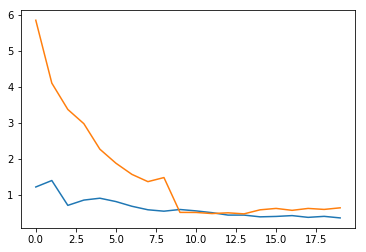

In [44]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

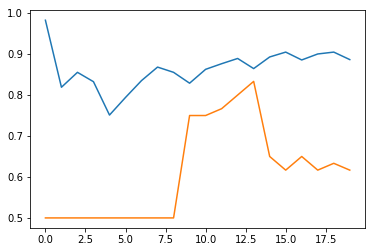

In [45]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])

# Save results

In [46]:
# Format results
y_true=np.expand_dims(stress.y_test,-1)
np.shape(pred_proba)
idxs_test=[int(i) for i in reserve.idxs_test]
idxs_val=[int(i) for i in reserve.idxs_val]

(30, 1)

In [48]:
my_dict=({f'acc_{model_n}':hist.history['acc'],
                         'loss':hist.history['loss'],
                         'val_acc':hist.history['val_acc'],
                         'val_loss':hist.history['val_loss'],
                         'test_pred':list(np.squeeze(pred_proba)),
                         'test_y_true':list(stress.y_test),
                         'idxs_test':idxs_test,
                         'idxs_val':idxs_val})

In [49]:
df_results=pd.DataFrame.from_dict(my_dict,orient='index')
df_results=df_results.transpose()
df_results.to_csv(f'polarmaps CNN results/polarmaps_model_{model_n}_fold{fold_seed}.csv',index=False)

# Save model visualization (if needed)

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model1, to_file='model_plot16.png', show_shapes=True, show_layer_names=True)